In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
import scipy.stats as scs
from pathlib import Path
import math
import matplotlib.pyplot as plt

In [2]:
Nout = 100000  # number of out-of-sample scenarios - True distribution
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

In [3]:
# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID   #100
driver = instr_data[:, 1]       # credit driver   #100
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)   #100
recov_rate = instr_data[:, 3]   # expected recovery rate   #100
value = instr_data[:, 4]        # value   #100
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)   #100x8
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)   #100x8
retn = instr_data[:, 5 + 2 * C] # market returns   #100

K = instr_data.shape[0]         # number of CPs - counterparties   #K = 100

In [4]:
# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))  #50x50
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)   #50x50

In [5]:
print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [6]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1   #100, credit state

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]   #100x8, replace the first column of exposure(default) to the recovered value

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))   #100x7, boundary

In [7]:
# -------- Insert your code here -------- #
Ndriver = len(rho) #Ndriver = 50


#if Path(filename_save_out+'.npz').is_file():
    #Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
    
if Path('Loss_sparse_matrix.npz').is_file():
    Losses_out = scipy.sparse.load_npz('Loss_sparse_matrix.npz')
else:
    # Generating Scenarios
    # -------- Insert your code here -------- #
    y = np.zeros((Nout, Ndriver))   #100000x50
    w = np.zeros((Nout, K))   #100000x100
    CS_new = np.zeros((Nout, K))
    Losses_out_nosparse = np.zeros((Nout, K))

    for s in range(1, Nout + 1):   #s from 1 to 100000
        # -------- Insert your code here -------- #
        normal_random_vector = np.random.randn(Ndriver,1)
        y[s-1] = (np.dot(sqrt_rho, normal_random_vector)).T
        z = np.random.randn(K,1)   #100x1
        for c in range(0, K):  #c = 0 to 99
            credit_driver_num = int(driver[c])
            sigma = np.sqrt(1 - beta[c]**2)
            w[s-1][c] = beta[c] * y[s-1][credit_driver_num - 1] + sigma * z[c]
            temp_array = np.append(CS_Bdry[c],w[s-1][c])
            temp_array = np.sort(temp_array)
            CS_index = np.where(temp_array==w[s-1][c])[0][0]
            CS_new[s-1][c] = CS_index + 1
            #print(exposure[c][CS_index])
            Losses_out_nosparse[s-1][c] = exposure[c][CS_index]
        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
    Losses_out = scipy.sparse.csc_matrix(Losses_out_nosparse)
    scipy.sparse.save_npz('Loss_sparse_matrix.npz', Losses_out)

In [8]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1), 1 share per stock
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2), equal weighted

x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

In [9]:
# Quantile levels (99%, 99.9%), for 2 portfolios
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

In [10]:
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        portfolio_loss = np.sort(np.dot(Losses_out.toarray(),x0[portN]))
        VaRout[portN, q] = portfolio_loss[int(math.ceil(Nout * alf)) - 1]
        VaRinN[portN, q] = np.mean(portfolio_loss) + scs.norm.ppf(alf) * np.std(portfolio_loss)
        CVaRout[portN, q] = (1 / (Nout*(1-alf))) * ((math.ceil(Nout*alf)- Nout*alf) * VaRout[portN, q] + sum(portfolio_loss[int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(portfolio_loss) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portfolio_loss)

In [11]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

In [13]:
portf_loss_inMC1 = np.zeros((K, 2, Nin))
portf_loss_inMC2 = np.zeros((K, 2, Nin))

In [14]:
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    y_inMC1 = np.zeros((np.int(np.ceil(Nin / Ns)), Ndriver))
    z_inMC1 = np.zeros((np.int(np.ceil(Nin / Ns)), Ns, K))
    w_inMC1 = np.zeros((np.int(np.ceil(Nin / Ns)), Ns, K))
    CS_new_inMC1 = np.zeros((np.int(np.ceil(Nin / Ns)), Ns, K))
    Losses_prep_inMC1 = np.zeros((np.int(np.ceil(Nin / Ns)), Ns, K))
    Losses_inMC1_nosparse = np.zeros((Nin, K))
    i = 0
    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        normal_random_vector = np.random.randn(Ndriver,1)
        y_inMC1[s-1] = np.transpose(np.dot(sqrt_rho, normal_random_vector))
        #y_inMC1[s-1] = np.random.multivariate_normal(np.zeros(Ndriver), sqrt_rho)
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z_inMC1[s-1][si-1] = np.random.randn(K)
            
    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1
            for c in range(0, K):
                credit_driver_num = int(driver[c])
                sigma = np.sqrt(1 - beta[c]**2)
                w_inMC1[s-1][si-1][c] = beta[c] * y_inMC1[s-1][credit_driver_num - 1] + sigma * z_inMC1[s-1][si-1][c]
                temp_array_inMC1 = np.append(CS_Bdry[c],w_inMC1[s-1][si-1][c])
                temp_array_inMC1 = np.sort(temp_array_inMC1)
                CS_index = np.where(temp_array_inMC1==w_inMC1[s-1][si-1][c])[0][0]
                CS_new_inMC1[s-1][si-1][c] = CS_index + 1
                Losses_prep_inMC1[s-1][si-1][c] = exposure[c][CS_index]
            i = i+1
            Losses_inMC1_nosparse[i-1] = Losses_prep_inMC1[s-1][si-1]
    Losses_inMC1 = scipy.sparse.csc_matrix(Losses_inMC1_nosparse)
    
    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    y_inMC2 = np.zeros((Nin, Ndriver))
    w_inMC2 = np.zeros((Nin, K))
    CS_new_inMC2 = np.zeros((Nin, K))
    Losses_inMC2_nosparse = np.zeros((Nin, K))
    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        normal_random_vector = np.random.randn(Ndriver,1)
        y_inMC2[s-1] = (np.dot(sqrt_rho, normal_random_vector)).T
        z_inMC2 = np.random.randn(K,1)

    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
        for c in range(0, K):
            credit_driver_num = int(driver[c])
            sigma = np.sqrt(1 - beta[c]**2)
            w_inMC2[s-1][c] = beta[c] * y_inMC2[s-1][credit_driver_num - 1] + sigma * z_inMC2[c]
            temp_array_inMC2 = np.append(CS_Bdry[c],w_inMC2[s-1][c])
            temp_array_inMC2 = np.sort(temp_array_inMC2)
            CS_index = np.where(temp_array_inMC2==w_inMC2[s-1][c])[0][0]
            CS_new_inMC2[s-1][c] = CS_index + 1
            Losses_inMC2_nosparse[s-1][c] = exposure[c][CS_index]
    Losses_inMC2 = scipy.sparse.csc_matrix(Losses_inMC2_nosparse)
    
    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1[tr-1, portN] = np.sort(np.dot(Losses_inMC1_nosparse,x0[portN]))
            portf_loss_inMC2[tr-1, portN] = np.sort(np.dot(Losses_inMC2_nosparse,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1.toarray(), rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2.toarray(), rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1, x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1[tr-1, portN])
            mu_p_MC2 = np.dot(mu_MC2, x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2[tr-1, portN])
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[tr-1, portN][int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[tr-1, portN][int(math.ceil(Nin * alf)) - 1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)- Nin*alf) * VaRinMC1[portN, q][tr - 1] + sum(portf_loss_inMC1[tr-1, portN][int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)- Nin*alf) * VaRinMC2[portN, q][tr - 1] + sum(portf_loss_inMC2[tr-1, portN][int(math.ceil(Nin*alf)):]))
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2

In [15]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $40401056.60, CVaR 99.0% = $49000977.67
In-sample MC1: VaR 99.0% = $39876214.49, CVaR 99.0% = $48276560.12
In-sample MC2: VaR 99.0% = $39786525.67, CVaR 99.0% = $48291351.41
In-sample No: VaR 99.0% = $27506189.71, CVaR 99.0% = $30588309.06
In-sample N1: VaR 99.0% = $27426380.44, CVaR 99.0% = $30496734.44
In-sample N2: VaR 99.0% = $27433929.99, CVaR 99.0% = $30503337.94

Out-of-sample: VaR 99.9% = $60170241.54, CVaR 99.9% = $69238614.00
In-sample MC1: VaR 99.9% = $58464335.32, CVaR 99.9% = $65930853.45
In-sample MC2: VaR 99.9% = $58276715.57, CVaR 99.9% = $67214616.76
In-sample No: VaR 99.9% = $34454011.51, CVaR 99.9% = $36972139.08
In-sample N1: VaR 99.9% = $34347680.38, CVaR 99.9% = $36856195.53
In-sample N2: VaR 99.9% = $34353097.32, CVaR 99.9% = $36860839.54


Portfolio 2:

Out-of-sample: VaR 99.0% = $30017862.89, CVaR 99.0% = $37127056.67
In-sample MC1: VaR 99.0% = $30001417.15, CVaR 99.0% = $36682317.45
In-sample MC2: VaR 99.0% = $29948331

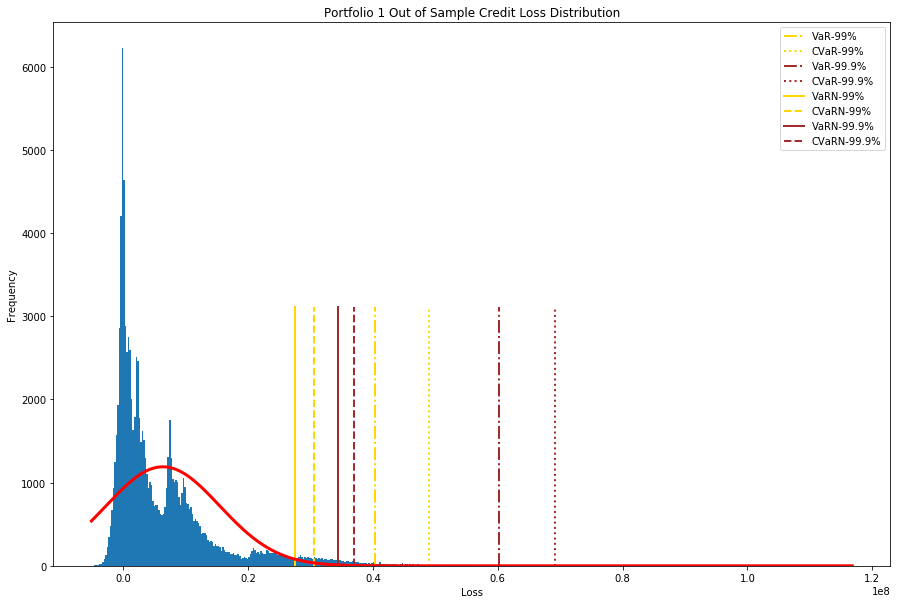

In [16]:
# Plot results
# Figure (1): Portfolio 1 Out of Sample Credit Loss Distribution
# -------- Insert your code here -------- #
Losses_out_portf1 = np.sort(np.dot(Losses_out.toarray(), x0[0]))
plt.figure(figsize=[15,10])
frequencyCounts, binLocations, patches = plt.hist(Losses_out_portf1,500)
normf = (1 / (np.std(Losses_out_portf1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_portf1)) / np.std(Losses_out_portf1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='-.') 
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dotted') 

plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='-.')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dotted')

plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='solid') 
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dashed') 

plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='solid')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dashed')

plt.legend(['VaR-99%','CVaR-99%','VaR-99.9%','CVaR-99.9%','VaRN-99%','CVaRN-99%','VaRN-99.9%','CVaRN-99.9%'])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Portfolio 1 Out of Sample Credit Loss Distribution')
plt.show()

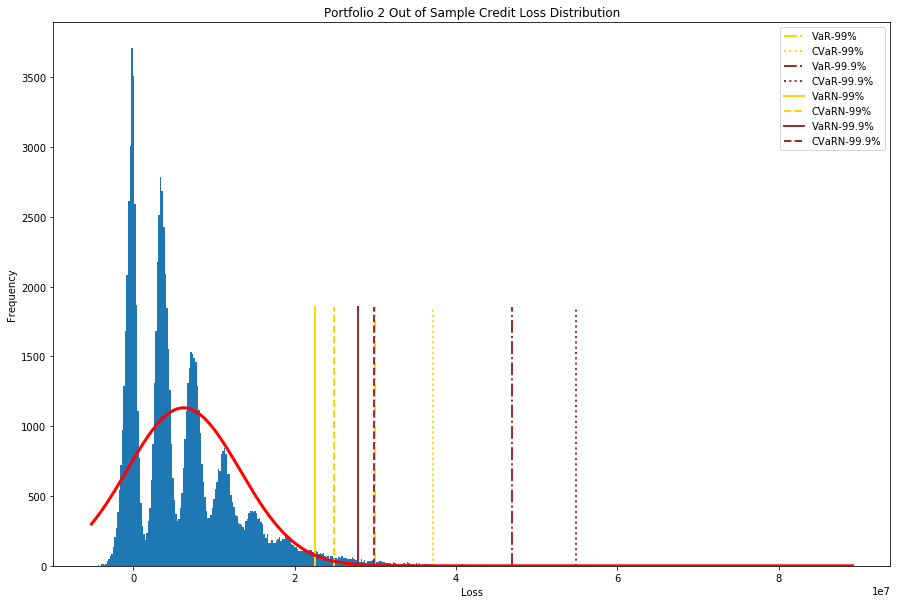

In [17]:
# Plot results
# Figure (2): Portfolio 2 Out of Sample Credit Loss Distribution
# -------- Insert your code here -------- #
Losses_out_portf2 = np.sort(np.dot(Losses_out.toarray(), x0[1]))
plt.figure(figsize=[15,10])
frequencyCounts, binLocations, patches = plt.hist(Losses_out_portf2,500)
normf = (1 / (np.std(Losses_out_portf2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_portf2)) / np.std(Losses_out_portf2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='-.') 
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dotted') 

plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='-.')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dotted')

plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='solid') 
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dashed') 

plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='solid')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dashed')

plt.legend(['VaR-99%','CVaR-99%','VaR-99.9%','CVaR-99.9%','VaRN-99%','CVaRN-99%','VaRN-99.9%','CVaRN-99.9%'])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Portfolio 2 Out of Sample Credit Loss Distribution')
plt.show()

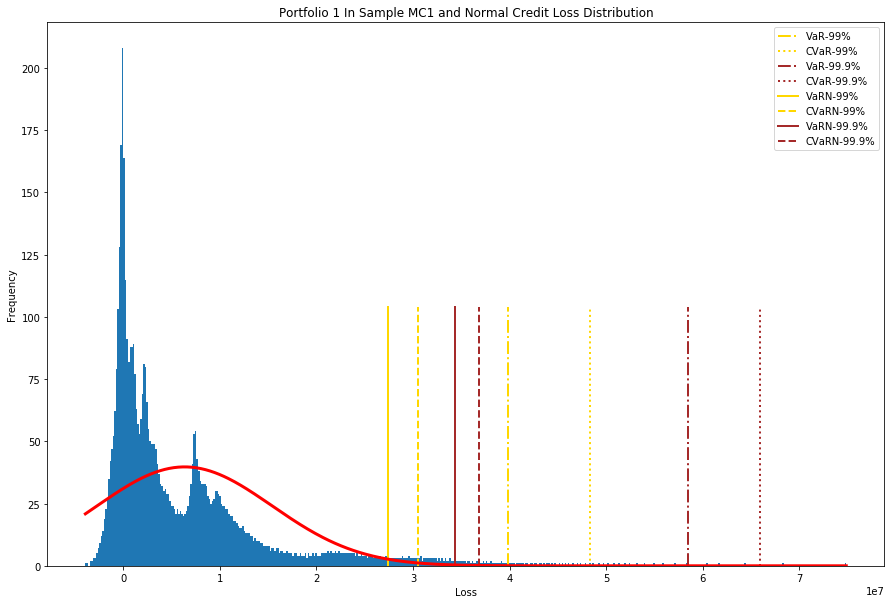

In [18]:
# Plot results
# Figure (3): Portfolio 1 In Sample MC1 and Normal Credit Loss Distribution
# -------- Insert your code here -------- #
portf1_loss_inMC1 = np.sum(portf_loss_inMC1, axis=0)[0]/N_trials
plt.figure(figsize=[15,10])
frequencyCounts, binLocations, patches = plt.hist(portf1_loss_inMC1,500)
normf = (1 / (np.std(portf1_loss_inMC1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf1_loss_inMC1)) / np.std(portf1_loss_inMC1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='-.') 
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dotted') 

plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dotted')

plt.plot([np.mean(VaRinN1[0,0]), np.mean(VaRinN1[0,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='solid')
plt.plot([np.mean(CVaRinN1[0,0]), np.mean(CVaRinN1[0,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dashed')

plt.plot([np.mean(VaRinN1[0,1]), np.mean(VaRinN1[0,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='solid')
plt.plot([np.mean(CVaRinN1[0,1]), np.mean(CVaRinN1[0,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dashed')


plt.legend(['VaR-99%','CVaR-99%','VaR-99.9%','CVaR-99.9%','VaRN-99%','CVaRN-99%','VaRN-99.9%','CVaRN-99.9%'])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Portfolio 1 In Sample MC1 and Normal Credit Loss Distribution')
plt.show()

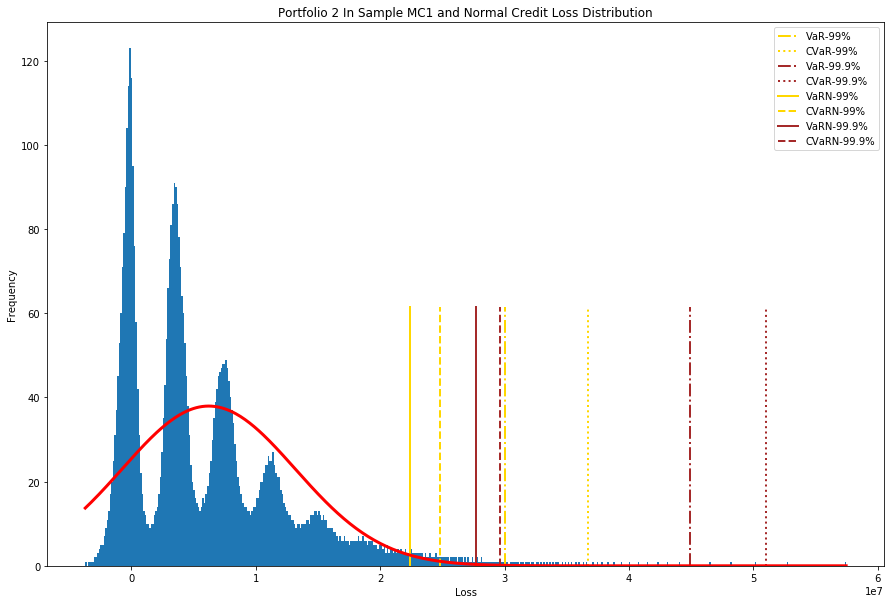

In [19]:
# Plot results
# Figure (4): Portfolio 2 In Sample MC1 and Normal Credit Loss Distribution
# -------- Insert your code here -------- #
portf2_loss_inMC1 = np.sum(portf_loss_inMC1, axis=0)[1]/N_trials
plt.figure(figsize=[15,10])
frequencyCounts, binLocations, patches = plt.hist(portf2_loss_inMC1,500)
normf = (1 / (np.std(portf2_loss_inMC1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf2_loss_inMC1)) / np.std(portf2_loss_inMC1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='-.') 
plt.plot([np.mean(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dotted') 

plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dotted')

plt.plot([np.mean(VaRinN1[1,0]), np.mean(VaRinN1[1,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='solid')
plt.plot([np.mean(CVaRinN1[1,0]), np.mean(CVaRinN1[1,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dashed')

plt.plot([np.mean(VaRinN1[1,1]), np.mean(VaRinN1[1,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='solid')
plt.plot([np.mean(CVaRinN1[1,1]), np.mean(CVaRinN1[1,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dashed')

plt.legend(['VaR-99%','CVaR-99%','VaR-99.9%','CVaR-99.9%','VaRN-99%','CVaRN-99%','VaRN-99.9%','CVaRN-99.9%'])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Portfolio 2 In Sample MC1 and Normal Credit Loss Distribution')
plt.show()

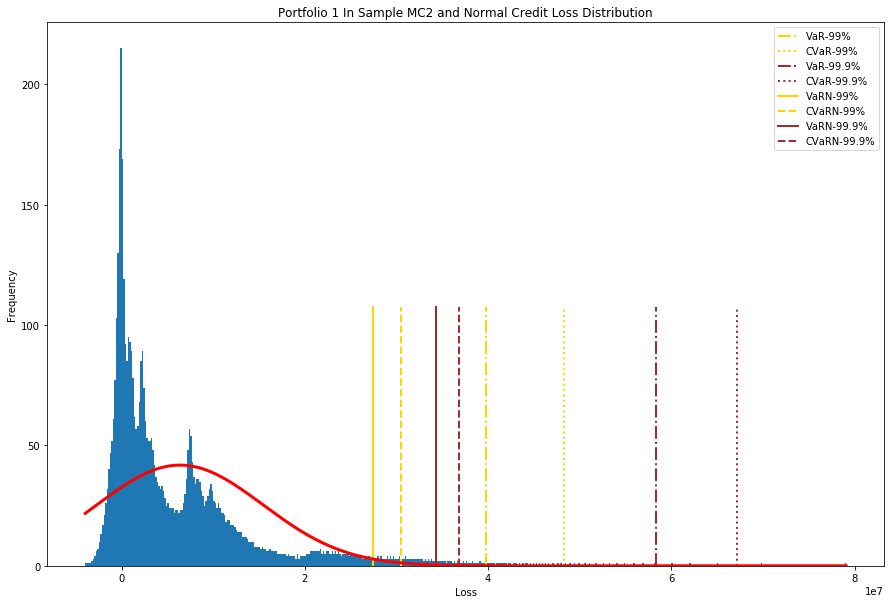

In [20]:
# Plot results
# Figure (5): Portfolio 1 In Sample MC2 and Normal Credit Loss Distribution
# -------- Insert your code here -------- #
portf1_loss_inMC2 = np.sum(portf_loss_inMC2, axis=0)[0]/N_trials
plt.figure(figsize=[15,10])
frequencyCounts, binLocations, patches = plt.hist(portf1_loss_inMC2,500)
normf = (1 / (np.std(portf1_loss_inMC2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf1_loss_inMC2)) / np.std(portf1_loss_inMC2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='-.') 
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dotted') 

plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dotted')

plt.plot([np.mean(VaRinN2[0,0]), np.mean(VaRinN2[0,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='solid')
plt.plot([np.mean(CVaRinN2[0,0]), np.mean(CVaRinN2[0,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dashed')

plt.plot([np.mean(VaRinN2[0,1]), np.mean(VaRinN2[0,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='solid')
plt.plot([np.mean(CVaRinN2[0,1]), np.mean(CVaRinN2[0,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dashed')

plt.legend(['VaR-99%','CVaR-99%','VaR-99.9%','CVaR-99.9%','VaRN-99%','CVaRN-99%','VaRN-99.9%','CVaRN-99.9%'])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Portfolio 1 In Sample MC2 and Normal Credit Loss Distribution')
plt.show()

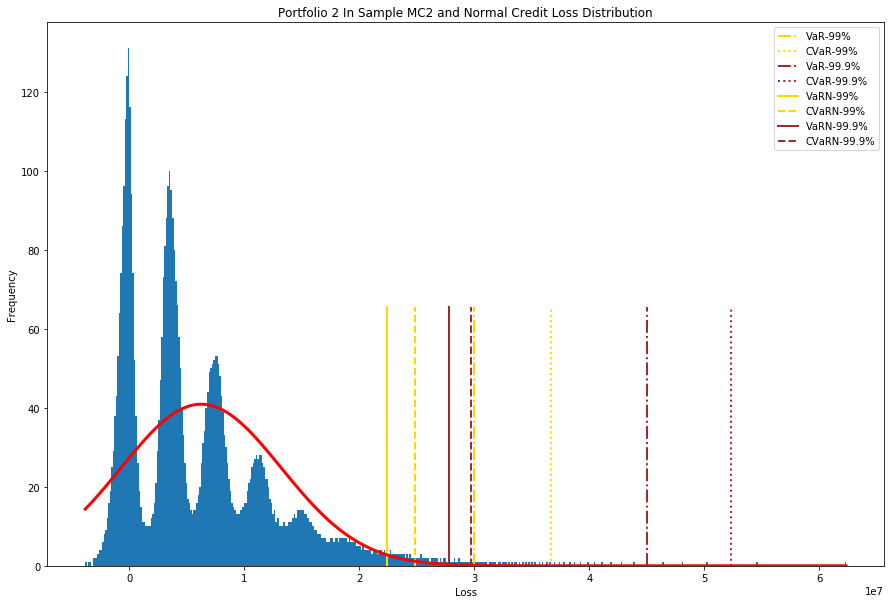

In [21]:
# Plot results
# Figure (6): Portfolio 2 In Sample MC2 and Normal Credit Loss Distribution
# -------- Insert your code here -------- #
portf2_loss_inMC2 = np.sum(portf_loss_inMC2, axis=0)[1]/N_trials
plt.figure(figsize=[15,10])
frequencyCounts, binLocations, patches = plt.hist(portf2_loss_inMC2,500)
normf = (1 / (np.std(portf2_loss_inMC2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf2_loss_inMC2)) / np.std(portf2_loss_inMC2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='-.') 
plt.plot([np.mean(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dotted') 

plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dotted')

plt.plot([np.mean(VaRinN2[1,0]), np.mean(VaRinN2[1,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='solid')
plt.plot([np.mean(CVaRinN2[1,0]), np.mean(CVaRinN2[1,0])], [0, max(frequencyCounts)/2], color='gold', linewidth=2, linestyle='dashed')

plt.plot([np.mean(VaRinN2[1,1]), np.mean(VaRinN2[1,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='solid')
plt.plot([np.mean(CVaRinN2[1,1]), np.mean(CVaRinN2[1,1])], [0, max(frequencyCounts)/2], color='brown', linewidth=2, linestyle='dashed')

plt.legend(['VaR-99%','CVaR-99%','VaR-99.9%','CVaR-99.9%','VaRN-99%','CVaRN-99%','VaRN-99.9%','CVaRN-99.9%'])
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Portfolio 2 In Sample MC2 and Normal Credit Loss Distribution')
plt.show()

In [23]:
True_mean_loss = [np.mean(np.dot(Losses_out.toarray(),x0[0])), np.mean(np.dot(Losses_out.toarray(),x0[1]))]
True_std_loss = [np.std(np.dot(Losses_out.toarray(),x0[0])), np.std(np.dot(Losses_out.toarray(),x0[1]))]
MC1_mean = [np.mean(np.mean(portf_loss_inMC1, axis=2), axis=0)[0], 
            np.mean(np.mean(portf_loss_inMC1, axis=2), axis=0)[1]]
MC1_std = [np.std(np.mean(portf_loss_inMC1, axis=2), axis=0)[0], 
            np.std(np.mean(portf_loss_inMC1, axis=2), axis=0)[1]]
MC2_mean = [np.mean(np.mean(portf_loss_inMC2, axis=2), axis=0)[0], 
            np.mean(np.mean(portf_loss_inMC2, axis=2), axis=0)[1]]
MC2_std = [np.std(np.mean(portf_loss_inMC2, axis=2), axis=0)[0], 
            np.std(np.mean(portf_loss_inMC2, axis=2), axis=0)[1]]
CI_MC1 = [[MC1_mean[0]-1.96*MC1_std[0]/10, MC1_mean[0]+1.96*MC1_std[0]/10],
          [MC1_mean[1]-1.96*MC1_std[1]/10, MC1_mean[1]+1.96*MC1_std[1]/10]]
CI_MC2 = [[MC2_mean[0]-1.96*MC2_std[0]/10, MC2_mean[0]+1.96*MC2_std[0]/10],
          [MC2_mean[1]-1.96*MC2_std[1]/10, MC2_mean[1]+1.96*MC2_std[1]/10]]
print('                                                Portfolio 1')
print("_____________________________________________________________________________________________________________")
print('True mean:', True_mean_loss[0], 'True std:', True_std_loss[0])
print('MC1 mean:', MC1_mean[0], 'MC1 std:', MC1_std[0], 'Confidence Interval:', CI_MC1[0])
print('MC2 mean:', MC2_mean[0], 'MC2 std:', MC2_std[0], 'Confidence Interval:', CI_MC2[0])

print('                                                Portfolio 2')
print("_____________________________________________________________________________________________________________")
print('True mean:', True_mean_loss[1], 'True std:', True_std_loss[1])
print('MC1 mean:', MC1_mean[1], 'MC1 std:', MC1_std[1], 'Confidence Interval:', CI_MC1[1])
print('MC2 mean:', MC2_mean[1], 'MC2 std:', MC2_std[1], 'Confidence Interval:', CI_MC2[1])

                                                Portfolio 1
_____________________________________________________________________________________________________________
True mean: 6347163.8403372 True std: 9095383.414946456
MC1 mean: 6348124.73691088 MC1 std: 193762.05144143556 Confidence Interval: [6310147.374828358, 6386102.098993401]
MC2 mean: 6362168.962271878 MC2 std: 110807.75964042918 Confidence Interval: [6340450.641382353, 6383887.283161402]
                                                Portfolio 2
_____________________________________________________________________________________________________________
True mean: 6239504.937651239 True std: 6996427.186114977
MC1 mean: 6211068.779914013 MC1 std: 168216.1710065288 Confidence Interval: [6178098.410396733, 6244039.149431293]
MC2 mean: 6234002.850337866 MC2 std: 86814.29837905482 Confidence Interval: [6216987.247855571, 6251018.45282016]
